In [25]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from data_processing.neural_networks.RL_Reinforced_Learning.RL_funcs import (base_env, plot_cliff_walking);
from IPython.display import clear_output
clear_output()
from misc_tools.print_latex import print_tex
plt.rcParams['figure.figsize'] = [4, 2]

*   Monte Carlo (MC) waits full episode and makes changes to state/action functions via full return $G_t$ (lets call this quantity a _target_).
    $$G_t \dot = R_{t+1}+ \gamma R_{t+2} + \dots + \gamma^{T- t - 1}R_T$$ 
*   Temporal Differences with 1 step (TD(0)) updates estimate of functions based on immediate reward and estimate of next reward. 
    $$G_{t:t+1} \dot = R_{t+1}+ \gamma V_{t}(S_{t+1})$$
    So TD does estimate based on estimate, which is called bootstrapping. 
    
    It introduces a bias towards previous estimate of state/action function.

    Subscript $t$ in $V_{t}(S_{t+1})$ shows that algorithm uses expected state reward which is up-to-date at time $t$.
    
*   One can try to do updates of state/action functions using parts of episodes and get remaining expected rewards with old state/action function.

    For example using two steps:
    $$G_{t:t+2} \dot = R_{t+1}+ \gamma R_{t+2} +  \gamma^2 V_{t+1}(S_{t+2})$$

    It is still considered a bootstrapping because we do estimate based on estimate, although with lesser extend.

    Its obvious that at time $t$ algorithm does not know $R_{t+2}$, which is in the future, so it has to wait until $t+1$ to get it, and then might as well use most up-to-date $V_{t+1}$.
    
* In general we can analyze n state transitions of an episode, this approach is called _n-step TD method_

    $$G_{t:t+n} \dot = R_{t+1}+ \gamma R_{t+2} + \dots +  \gamma^{n-1} R_{t+n} + \gamma^n V_{t+n -1}(S_{t+n})$$

    By similar logic as in two-step TD, $G_{t:t+n}$ can be evaluated only at $t+n-1$

*   n-step state-value update algorithm then is the following
$$V_{t+n}(S_t) \dot = V_{t+n-1}(S_t) + \alpha \bigg[ G_{t:t+n} - V_{t+n-1}(S_t) \bigg]$$

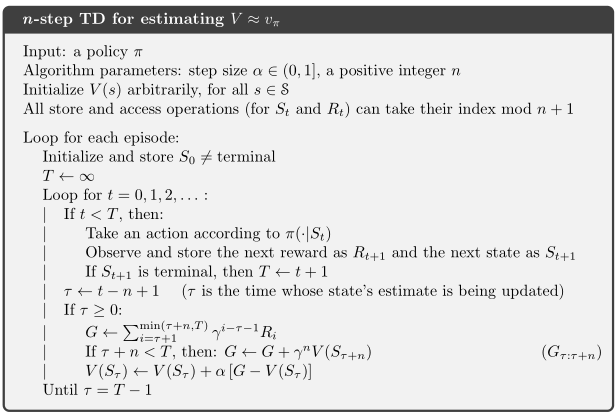

1.  Algorithm does n iterations until $t$ is $n$ steps past init which now can be backed up.
    $\tau$ is a counter for backe up state. It is negative at start, until $t = n-1$.<br>_($t$ is counted from 0)_
    $$\tau = 0 = t-n+1 \rightarrow t = n-1$$
    
2.  If Terminal state __is not__ reached in $n$ steps:
    1.  Algorithm will continue to loop $n$ steps ahead of initial state $t=0$, collecting new rewards.
    2.  Until that, $\tau$ block will be skipped. If $\tau = 0$:
    3.  Calculate $n$ steps of rewards ($G_{\tau:\tau+n}$)
    4.  Add rewards past $n$ steps as state value ($\gamma^n\cdot V(S_{\tau+n})$).
3.  If Terminal state __is__ reached faster than $n$ steps:
    1.  Set terminal time to next time step. !Next iterations will skip taking actions!
    2.  $\tau$ block will be skipped and main loop will continue until $t = n-1$
    3.  $G$ will be calculated with whatever trajectory there is
    4.  Because terminal state is reached, there is no need to add value state.
    
    Ignore next shit. this algo is overly convoluted. Could have covered early terminal state straight away.

    Although i think its needed this way because everything ill terminate at some point, and we need 'ghost' time steps to cover $n$ steps forward.

    %% For example for $n = 3$ terminal state reached at $t = 1$, so $T = 2$, $t = [0,1,2,3]$, $\tau = [-2,-1,0,1]$, $R = [0,R_1,R_2]$

    %% Algorithm will idle from $t = 1$ to $t = 2$ when $\tau$ becomes $0$

In [20]:
# completely random policy: epsilon = 1.
# env_nTD_V = base_env('FrozenLake-v1', desc=None, map_name="4x4", eps=1)

env_nTD_V = base_env("CliffWalking-v0", eps=0.5)
env_nTD_V.Qsa_init(random=False, action=1)
env_nTD_V.Qsa[37:] *= 0
env_nTD_V.Qsa[36] = [0,1,0,0]
env_nTD_V.policy_update_whole(use_Qsa = True)

In [21]:
def n_step_TD_V(env: base_env, n_steps = 5, N = 1, GAMMA = 1, ALPHA = 0.01):

    tq_iter = tqdm(range(N))
    for i in tq_iter:
        t = 0
        state           = env.reset()    
        mem = [state]
        rews = [-1000]  # dummy reward R_0 so next is R_{t+1}
        T = float("inf")
        while True:
            if t < T:
                action                      = env.sample_action(state, use_Qsa=False)
                state_prime, reward, done   = env.step(action)
                mem.append(state_prime)
                rews.append(reward)
                if done:
                    T = t + 1
            tau = t - n_steps + 1
            if tau >= 0:
                # add +1 to end range to include it.
                G = sum([GAMMA**(i-tau-1)*rews[i] for i in range(tau+1, min(tau+n_steps,T) + 1)])
                if tau + n_steps < T:
                    G += GAMMA**n_steps*env.Vs[mem[tau+n_steps]]
                env.Vs[mem[tau]] = env.Vs[mem[tau]] + ALPHA*(G - env.Vs[mem[tau]])
              
                #tq_iter.set_postfix(eps=env.eps, s = s)
            t += 1
            
            if tau == T - 1:
                break
    return

n_step_TD_V(env_nTD_V, n_steps = 5, N = 2000, GAMMA = 1, ALPHA = 0.01)

  0%|          | 0/2000 [00:00<?, ?it/s]c:\Users\Hot Mexican\VS_Code_Proj\.venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 2000/2000 [00:20<00:00, 95.55it/s] 


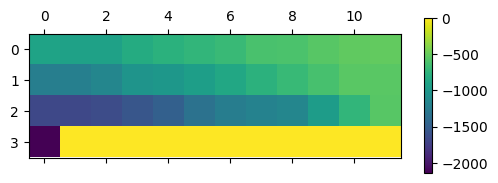

In [22]:
c = plt.matshow(env_nTD_V.Vs.reshape(4,12))
plt.colorbar(c)

## n-step SARSA


$$G_{t:t+n} = \underbrace{R_{t+1} + \gamma R_{t+2} + \dots + \gamma^{n-1} R_{t+n}}_{\text{n rewards}} + \gamma^n \underbrace{Q_{t+n-1}(S_{t+n}, A_{t+n})}_{\text{estimated future reward}}$$

Given that we dont take action from terminal state $Q(S_T,A_T)$, for $S_{t+n}$
$$0\leq t+n \lt T \longrightarrow 0 \leq t \lt T-n$$

Again, at time $t+n-1$ we make action and get reward $R_{t+n}$, so we use most up-to-date estimate $Q_{t+n-1}$

For early termination: $t + n \geq T$ (for example $n = 5$, termination after 2 steps: $t + 5 \geq T = t + 2$
$$G_{t:t+n} = G_t$$
Update rule:
$$Q_{t+n}(S_t,A_t) = Q_{t+n-1}(S_t,A_t) + \alpha \bigg[ G_{t:t+n} - Q_{t+n-1}(S_t,A_t)\bigg]$$

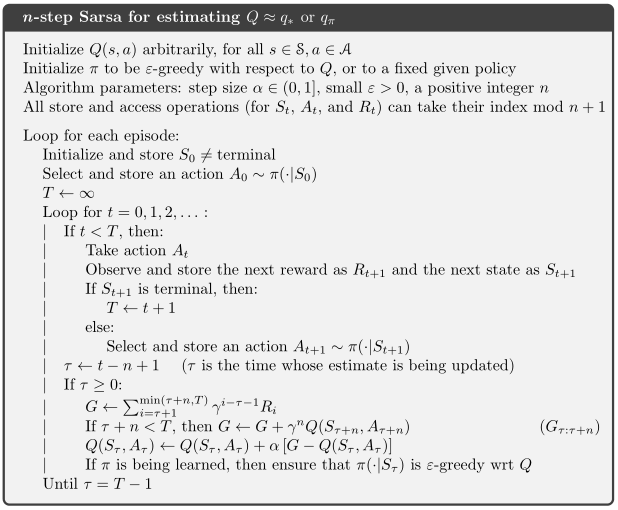

In [23]:
env_nSARSA_Q = base_env("CliffWalking-v0", eps=0.1)
env_nSARSA_Q.Qsa_init(random=False, action=1)
env_nSARSA_Q.Qsa[37:] *= 0
env_nSARSA_Q.Qsa[36] = [0,1,0,0]
#env_nSARSA_Q.policy_update_whole(use_Qsa = True)

100%|██████████| 2000/2000 [00:06<00:00, 317.62it/s]


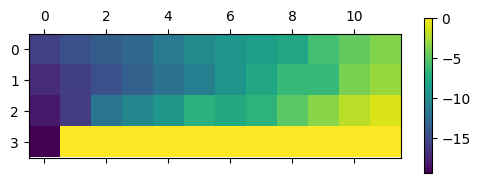

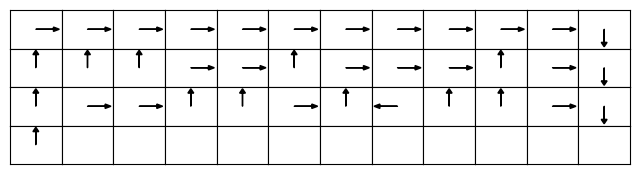

In [29]:
def n_step_SARSA_Q(env: base_env, n_steps = 5, N = 1, GAMMA = 1, ALPHA = 0.01):

    tq_iter = tqdm(range(N))
    for i in tq_iter:
        t = 0
        state           = env.reset()    
        action          = env.sample_action(state, use_Qsa=True)
        mem = [state]
        actions = [action]
        rews = [-1000]  # dummy reward R_0 so next is R_{t+1}
        T = float("inf")
        while True:
            if t < T:
                state_prime, reward, done   = env.step(action)
                mem.append(state_prime)
                rews.append(reward)
                if done:
                    T = t + 1
                else:
                    action  = env.sample_action(state_prime, use_Qsa=True)
                    actions.append(action)
            tau = t - n_steps + 1
            if tau >= 0:
                # add +1 to end range to include it.
                G = sum([GAMMA**(i-tau-1)*rews[i] for i in range(tau+1, min(tau+n_steps,T) + 1)])
                if tau + n_steps < T:
                    G += GAMMA**n_steps*env.Qsa[mem[tau+n_steps]][actions[tau+n_steps]]
                SA_tau = mem[tau] + (actions[tau],)
                env.Qsa[SA_tau] = env.Qsa[SA_tau]+ ALPHA*(G - env.Qsa[SA_tau])
              
                #tq_iter.set_postfix(eps=env.eps, s = s)
            t += 1
            
            if tau == T - 1:
                break
    return

n_step_SARSA_Q(env_nSARSA_Q, n_steps = 5, N = 2000, GAMMA = 1, ALPHA = 0.01)

c = plt.matshow(env_nSARSA_Q.Qsa.max(-1).reshape(4,12))
plt.colorbar(c)

env_nSARSA_Q.policy_update_whole(use_Qsa = True)
env_nSARSA_Q.policy[37:] *= 0
plot_cliff_walking(env_nSARSA_Q.policy, figsize=(8,2))


# n-step SARSA using improtance sampling
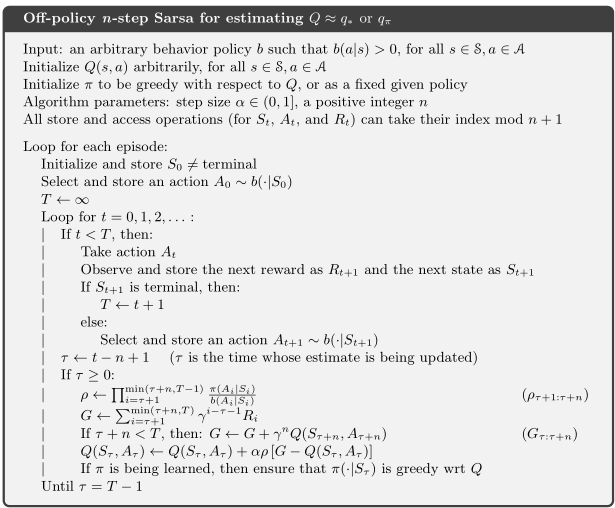

In [140]:

class base_env_importance_sampling(base_env):
    """
        Added sampling from behavior policy
    """
    def __init__(self, env_name, *args, eps=0.1, **kwargs):
        super().__init__(env_name, *args, eps=eps, **kwargs)
        self.policy_behavior = np.zeros_like(self.policy)

    def sample_action_behavior(self, state):
        policy = self.policy_behavior[state]
        return np.random.choice(self.actions, p= policy)
    
    def update_policy_state_based_on_Qsa(self,state, eps = None):
        eps = self.eps if eps is None else eps
        action = self.best_action(state) # with random tie break
        policy = np.ones_like(self.actions)*eps/(self.NUM_ACTIONS)
        policy[action] = (1 - eps + eps/(self.NUM_ACTIONS))
        self.policy[state] = policy
    
    
env_nSARSA_Q_IS = base_env_importance_sampling("CliffWalking-v0", eps=0.33)
# generate behavior policy thats exploratory
env_nSARSA_Q_IS.Qsa_init(random=False, action=1)
env_nSARSA_Q_IS.Qsa[37:] *= 0
env_nSARSA_Q_IS.Qsa[36] = [0,1,0,0]
env_nSARSA_Q_IS.policy_update_whole(use_Qsa = True)
env_nSARSA_Q_IS.policy_behavior = env_nSARSA_Q_IS.policy.copy()
# switch learnable policy to random
env_nSARSA_Q_IS.eps = 0.01
env_nSARSA_Q_IS.policy_update_whole(use_Qsa = False)   #Qsa-False, action-None

env_nSARSA_Q_IS.policy[36]
# plot random initial policy
#plot_cliff_walking(env_nSARSA_Q_IS.policy, figsize=(8,2))


array([0.0025, 0.9925, 0.0025, 0.0025])

100%|██████████| 10000/10000 [03:35<00:00, 46.39it/s]


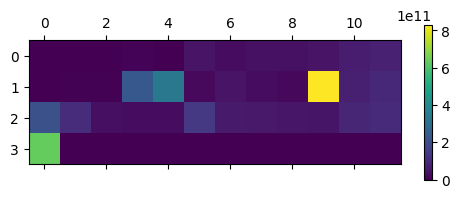

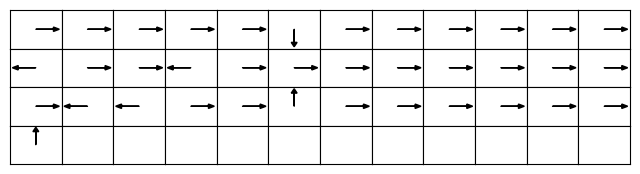

In [143]:
def n_step_SARSA_Q_IS(env: base_env_importance_sampling, n_steps = 5, N = 1, GAMMA = 1, ALPHA = 0.01):
    store_Qs = {}
    tq_iter = tqdm(range(N))
    for z in tq_iter:
        t = 0
        state           = env.reset()    
        action          = env.sample_action_behavior(state)
        mem = [state]
        actions = [action]
        rews = [-1000]  # dummy reward R_0 so next is R_{t+1}
        T = float("inf")
        while True:
            if t < T:
                state_prime, reward, done   = env.step(action)
                mem.append(state_prime)
                rews.append(reward)
                if done:
                    T = t + 1
                else:
                    action  = env.sample_action_behavior(state_prime)
                    actions.append(action)
            tau = t - n_steps + 1
            if tau >= 0:
                frac = lambda i, actions, states: env.policy[states[i]][actions[i]]/env.policy_behavior[states[i]][actions[i]]  # new
                
                RHO = np.prod([frac(i,actions,mem) for i in range(tau+1, min(tau+n_steps,T-1) + 1)])                              # new
                # add +1 to end range to include it.
                G = sum([GAMMA**(i-tau-1)*rews[i] for i in range(tau+1, min(tau+n_steps,T) + 1)])
                if tau + n_steps < T:
                    G += GAMMA**n_steps*env.Qsa[mem[tau+n_steps]][actions[tau+n_steps]]
                SA_tau = mem[tau] + (actions[tau],)
                env.Qsa[SA_tau] = env.Qsa[SA_tau]+ ALPHA*RHO*(G - env.Qsa[SA_tau])      # added RHO
                env.update_policy_state_based_on_Qsa(mem[tau])                          # new
                #tq_iter.set_postfix(eps=env.eps, s = s)
            t += 1
            
            if tau == T - 1:
                break 
        if z % (N//10) == 0:
                store_Qs[z] = env.Qsa.max(-1).reshape(4,12)
    store_Qs[z] = env.Qsa.max(-1).reshape(4,12)
    return store_Qs

store_Qs = n_step_SARSA_Q_IS(env_nSARSA_Q_IS, n_steps = 5, N = 10000, GAMMA = 1, ALPHA = 0.01)

c = plt.matshow(env_nSARSA_Q_IS.Qsa.max(-1).reshape(4,12))
plt.colorbar(c)

env_nSARSA_Q_IS.policy_update_whole(use_Qsa = True)
env_nSARSA_Q_IS.policy[37:] *= 0
plot_cliff_walking(env_nSARSA_Q_IS.policy, figsize=(8,2))

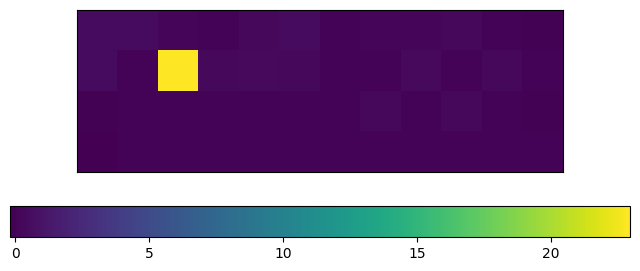

In [144]:
import matplotlib.animation as animation

sorted_time_steps = list(store_Qs.keys())
fig, ax = plt.subplots(figsize=(8,3))
cax = ax.matshow(store_Qs[sorted_time_steps[0]], cmap='viridis')
fig.colorbar(cax, location='bottom')
ax.set_xticks([])
ax.set_yticks([])

def init():
    cax.set_array(store_Qs[sorted_time_steps[0]])
    return [cax]

def update(frame):
    matrix = store_Qs[sorted_time_steps[frame]]
    cax.set_array(matrix)
    fig.suptitle(f'episode: {sorted_time_steps[frame]}')
    return [cax]

ani = animation.FuncAnimation(fig, update, frames=len(sorted_time_steps), init_func=init, interval=500, blit=True);

In [145]:
from IPython.display import HTML
display(HTML(ani.to_html5_video()))
list(store_Qs)

[0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 9999]